In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model
from conv_utils import *

Using TensorFlow backend.


# Data Preprocessing

In [3]:
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange', 'kiwi']
# data_dict = {}
# for symbol in symbol_list:
#     data_dict[symbol] = load_raw_data(symbol)

# 
# symbol,fruit,open,close
# es,apple,08:30:00 AM,03:15:00 PM
# ty,orange,07:20:00 AM,02:00:00 PM
# gl,grape,08:00:00 AM,04:30:00 PM
# ft,cherry,08:00:00 AM,04:30:00 PM
# xx,peach,09:00:00 AM,05:30:00 PM
# bl,pear,09:00:00 AM,05:30:00 PM
# cl,banana,09:00:00 AM,02:30:00 PM
# gc,kiwi,08:20:00 AM,01:30:00 PM
# 

In [4]:
RawData = load_raw_data(symbol='kiwi', trading_start=510, trading_end=810)

5371it [00:14, 380.12it/s]


In [5]:
X_train, X_test, X_valid = RawData

In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3753, 300, 1)
(896, 300, 1)
(356, 300, 1)


# Convolutional Autoencoder with Conv1D layers

$$new\ width(height) = \frac{width(height) - F + 2 \times P}{S} + 1$$

In [7]:
timesteps = 300 #1440
input_dim = 1

n_epochs = 300
batch_size = 32

In [9]:
encoder = Sequential([
    Input(shape=(timesteps, input_dim)),
    
    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5, padding='valid'),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3, padding='valid'),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2, padding='valid'),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2, padding='valid'),
])

In [10]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 300, 6)            18        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 300, 6)            24        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 6)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 6)             78        
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 60, 6)             24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 6)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 8)             1

In [11]:
Conv1DAuto = Sequential([
    encoder,
    
    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(2),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(2),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(3),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(5),
    Conv1D(filters=1, kernel_size=2, strides=1, padding='causal', activation='sigmoid'),
])

In [12]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_V4_daySession.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [13]:
Conv1DAuto.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [15]:
history = Conv1DAuto.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid), 
                        verbose=False)

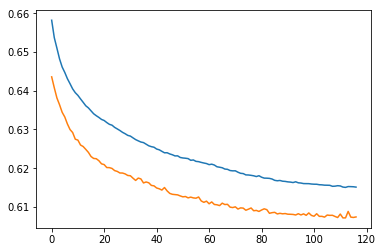

In [44]:
_ = plt.plot(history.history['loss'][6:])
_ = plt.plot(history.history['val_loss'][6:])

In [43]:
Conv1DAuto.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 5, 8)              448       
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  136       
_________________________________________________________________
batch_normalization_v2_4 (Ba multiple                  32        
_________________________________________________________________
up_sampling1d (UpSampling1D) multiple                  0         
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  136       
_________________________________________________________________
batch_normalization_v2_5 (Ba multiple                  32        
_________________________________________________________________
up_sampling1d_1 (UpSampling1 multiple                 

# How the reconstruction looks?

In [17]:
X_pred = Conv1DAuto.predict(X_test)

C:\Users\vhuang\Anaconda3\envs\py36tf2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


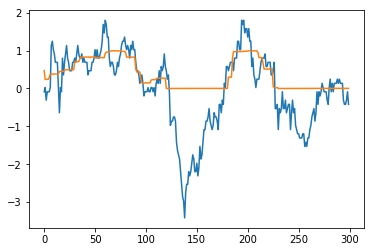

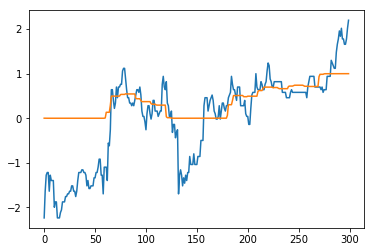

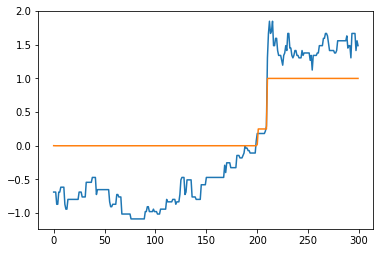

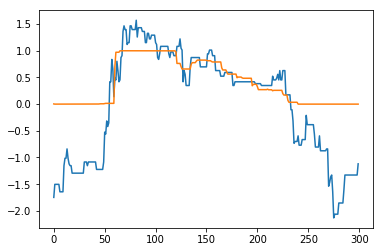

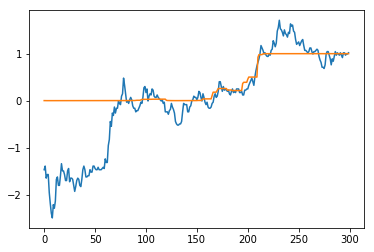

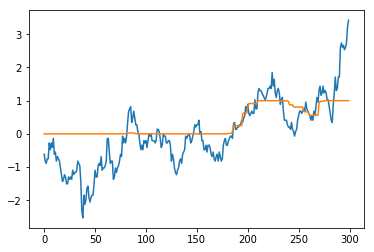

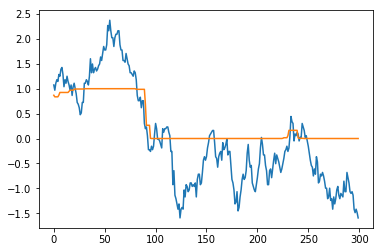

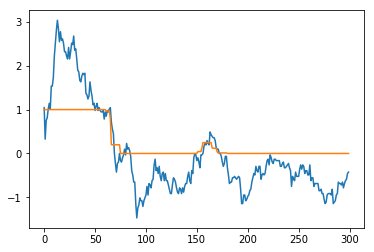

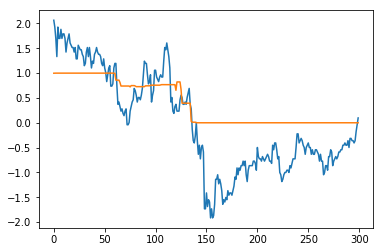

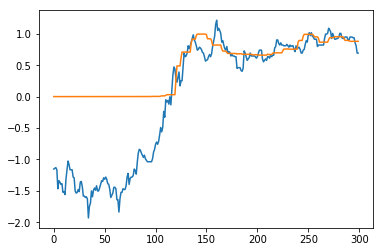

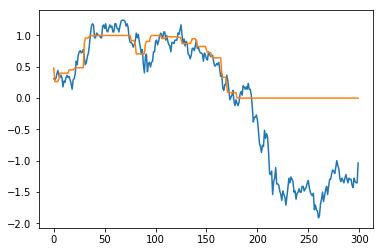

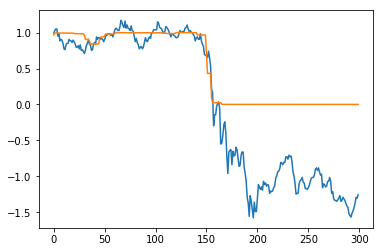

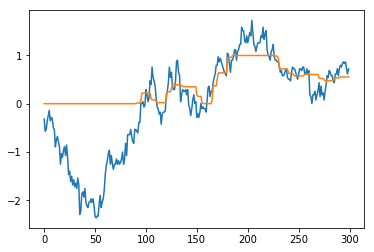

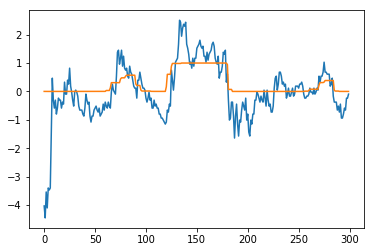

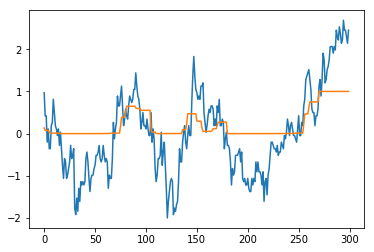

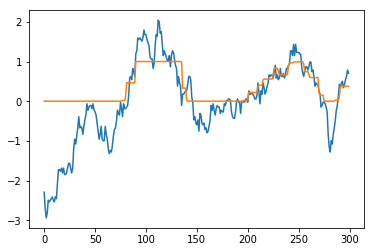

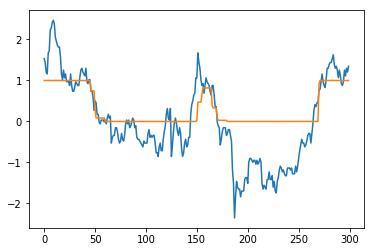

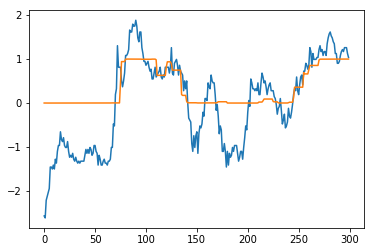

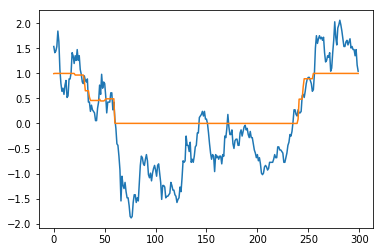

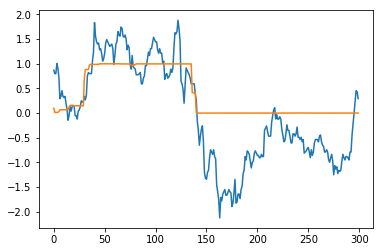

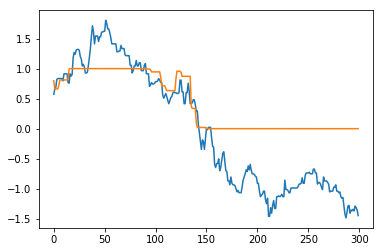

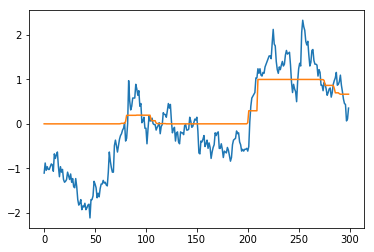

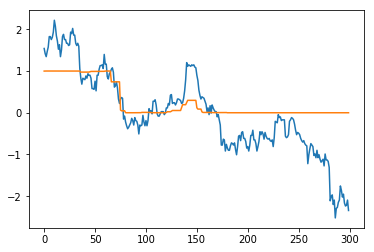

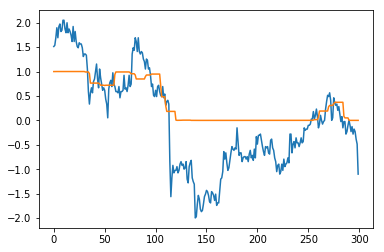

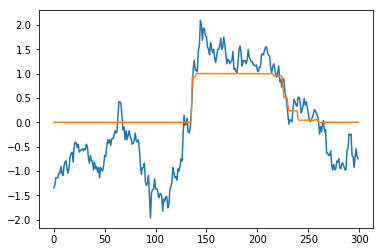

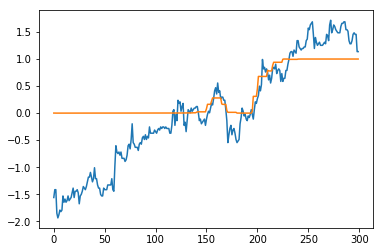

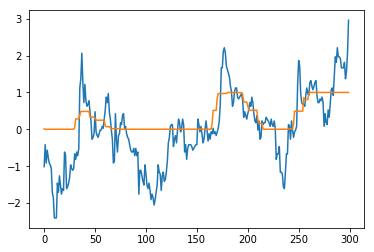

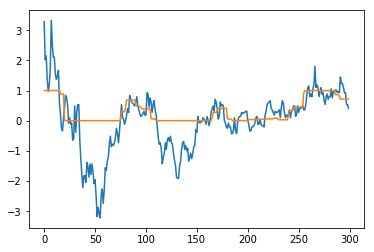

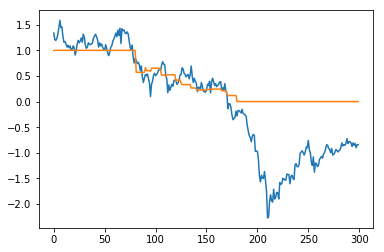

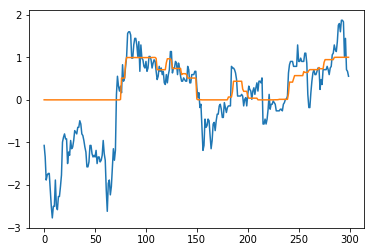

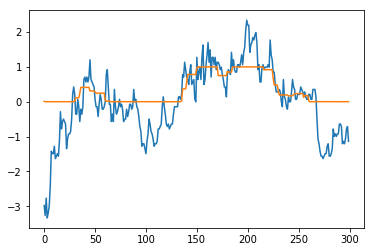

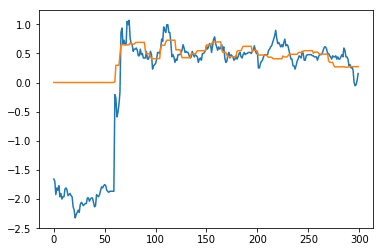

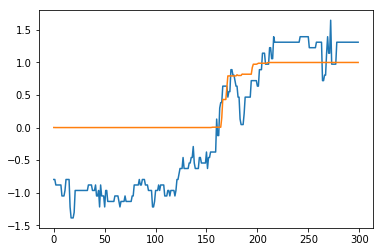

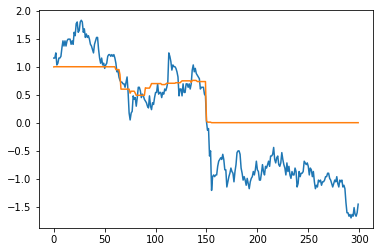

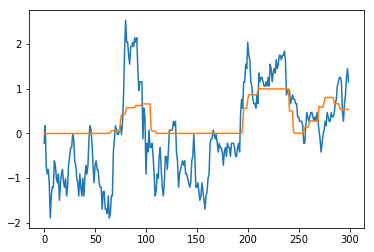

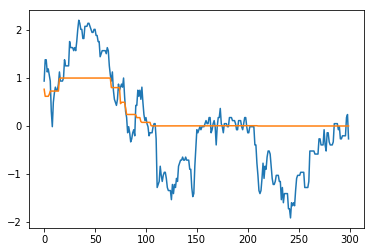

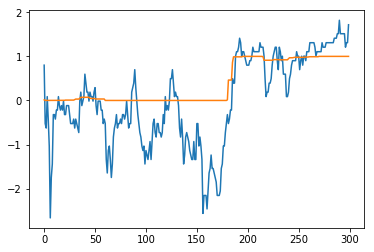

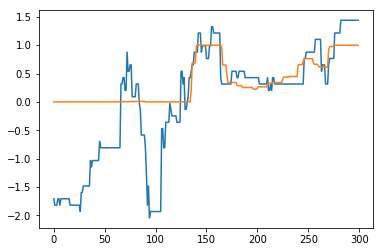

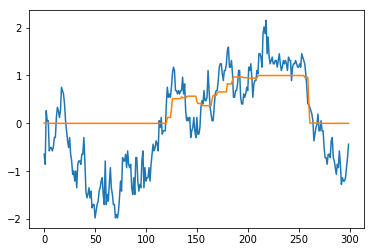

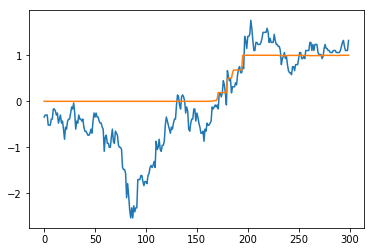

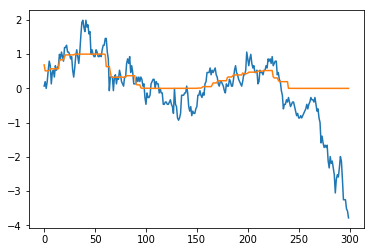

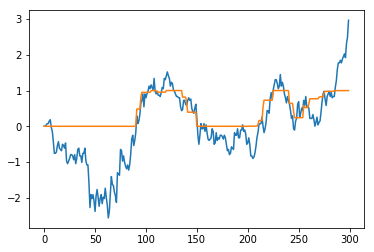

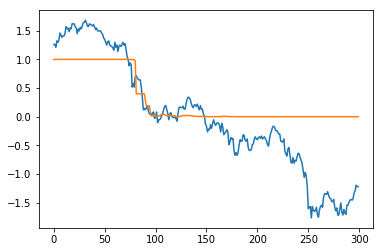

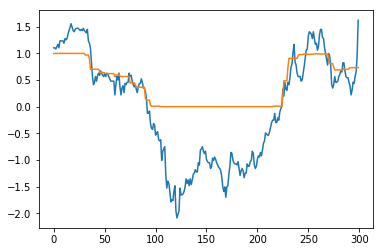

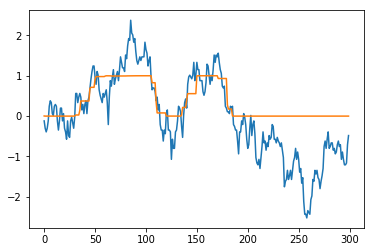

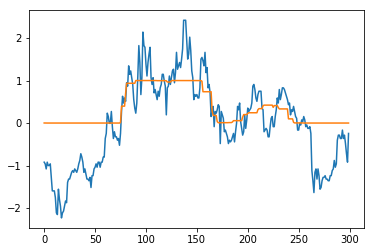

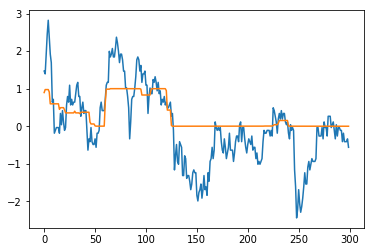

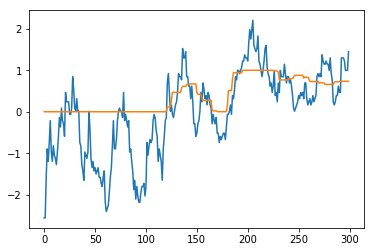

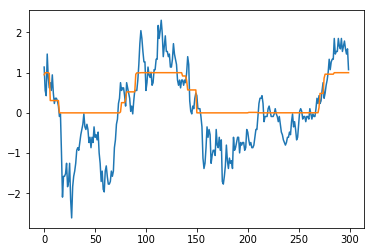

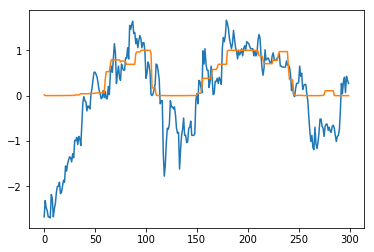

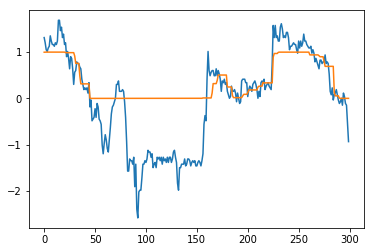

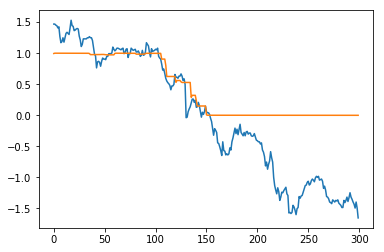

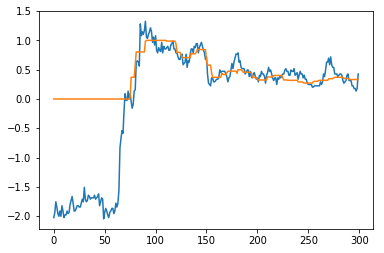

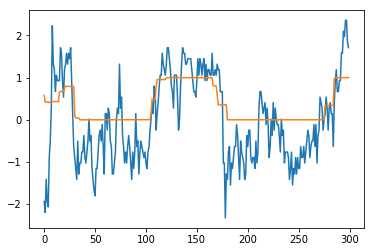

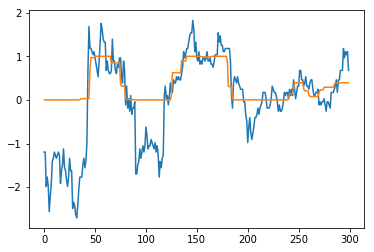

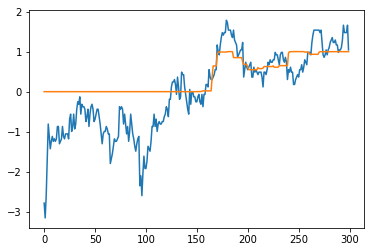

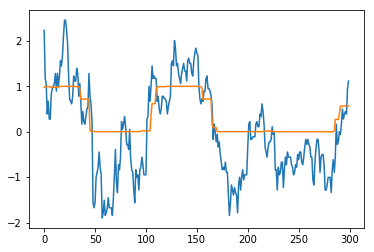

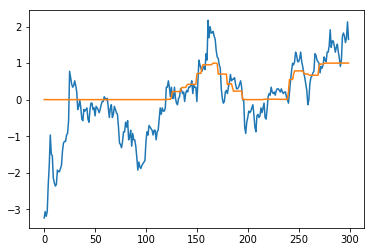

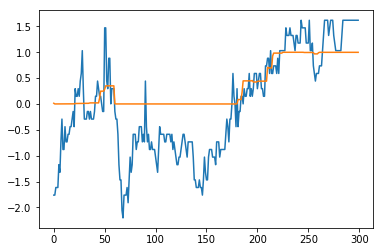

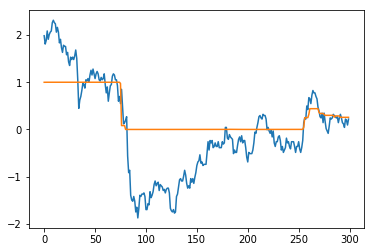

In [18]:
for i in range(len(X_pred)):
    if i % 15 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test[i])
        plt.plot(X_pred[i])

# How the Encoded looks?

In [19]:
X_test_encoded = encoder.predict(X_test)

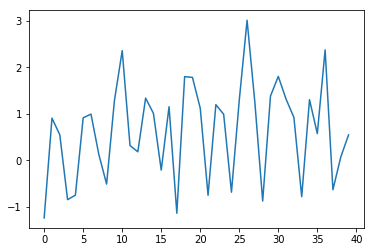

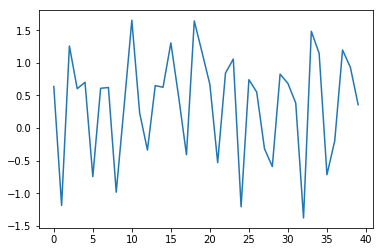

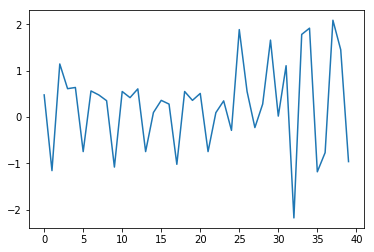

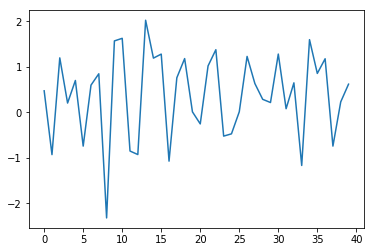

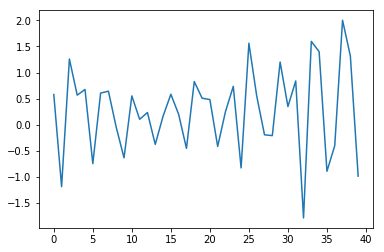

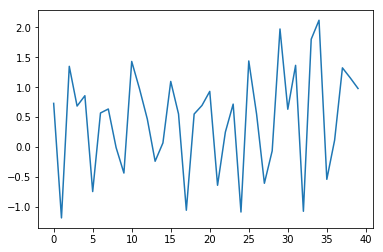

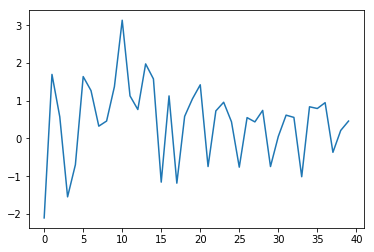

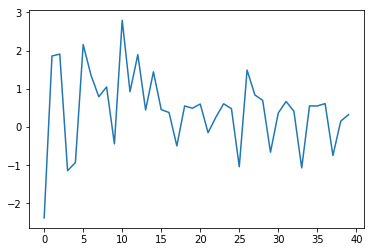

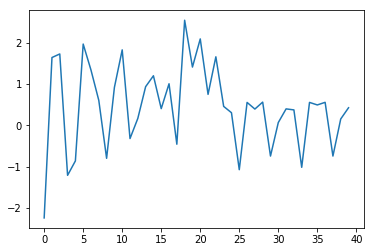

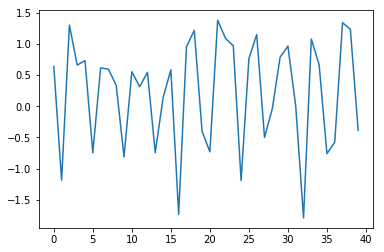

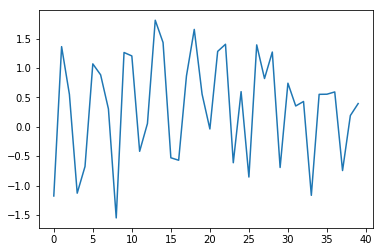

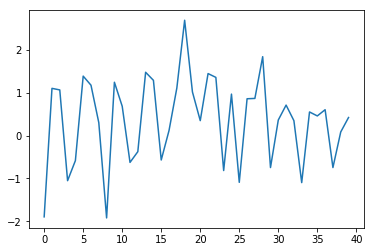

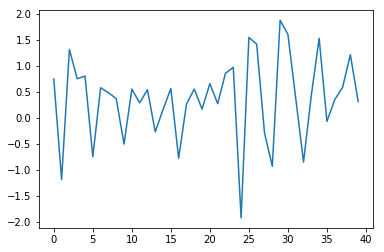

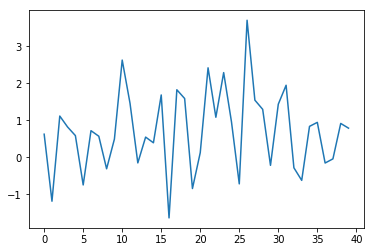

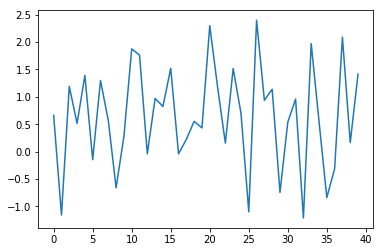

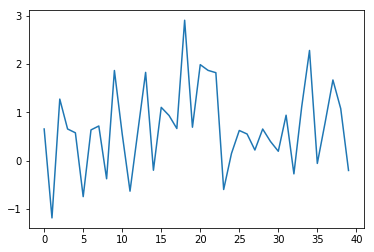

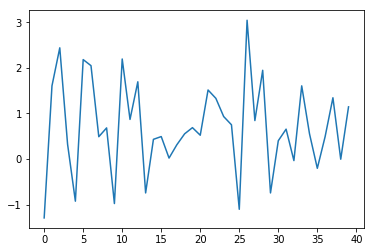

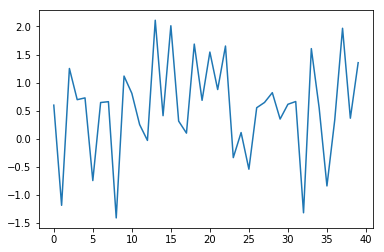

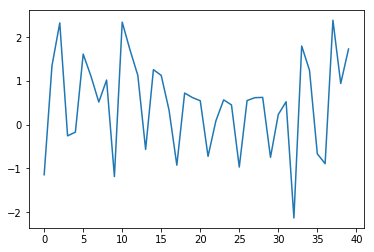

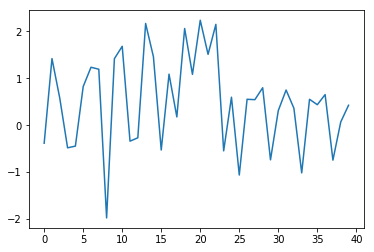

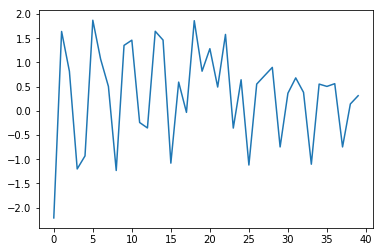

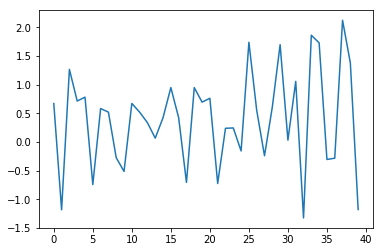

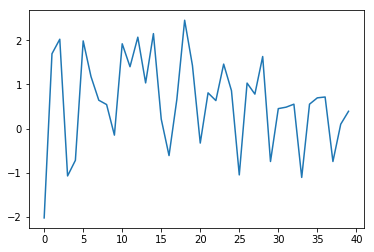

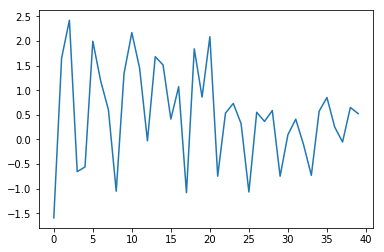

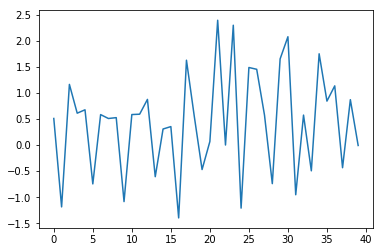

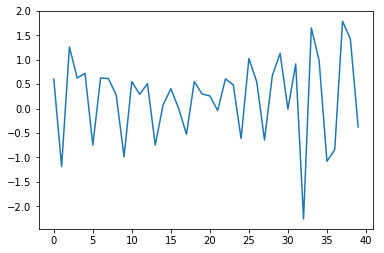

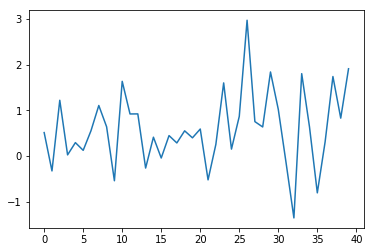

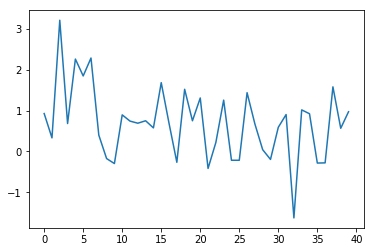

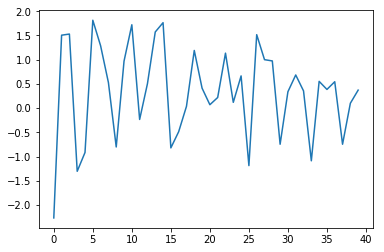

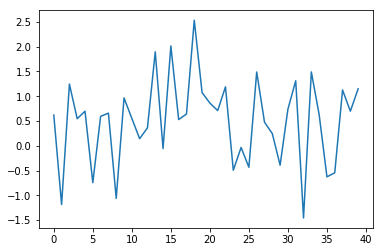

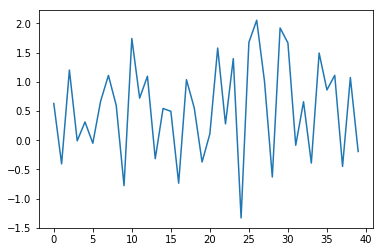

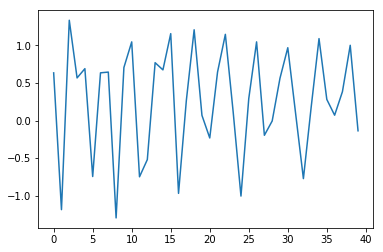

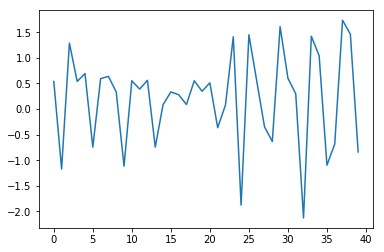

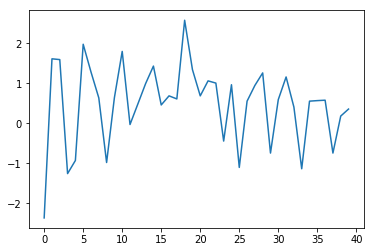

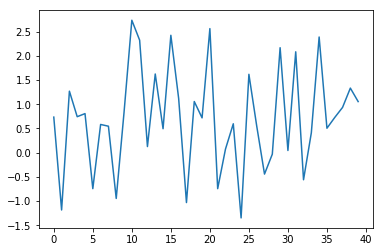

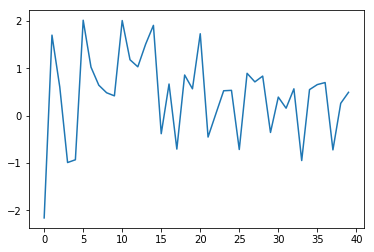

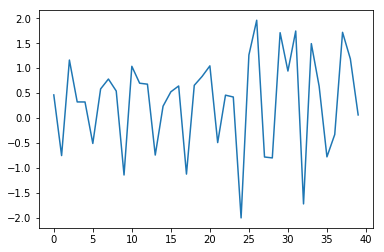

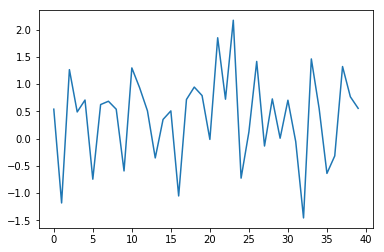

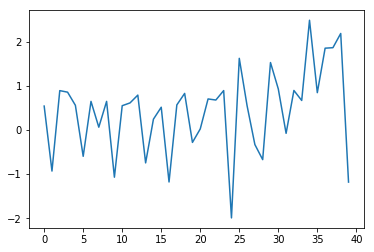

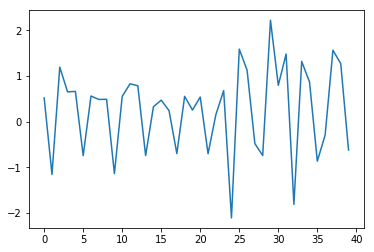

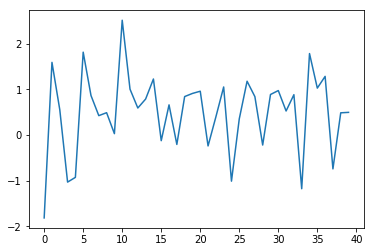

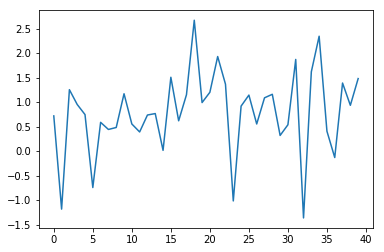

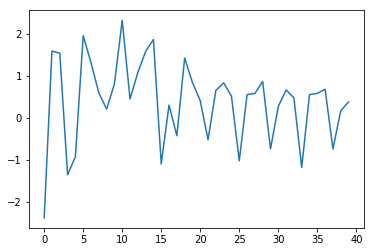

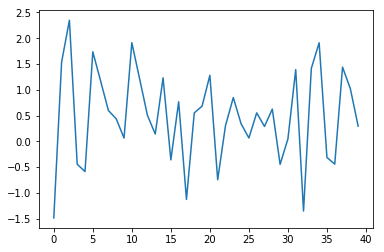

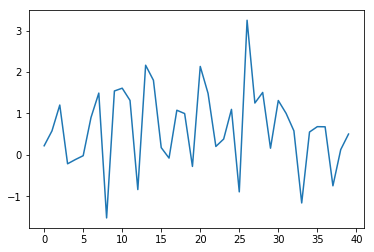

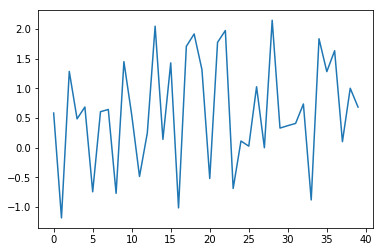

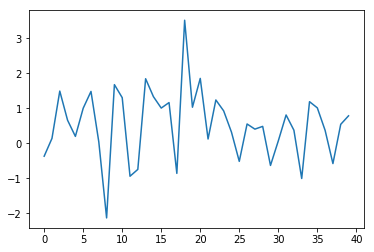

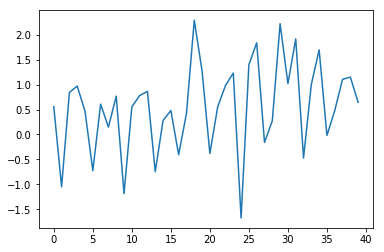

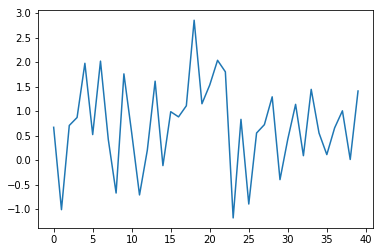

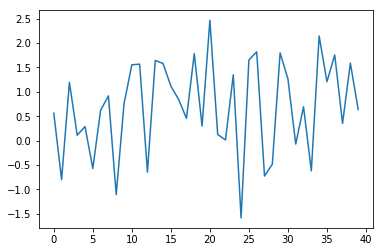

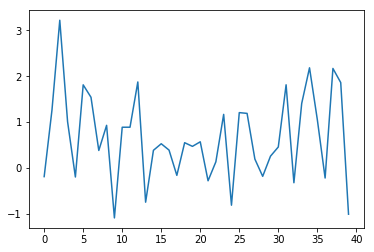

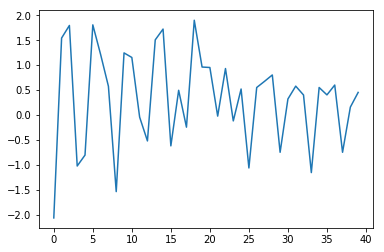

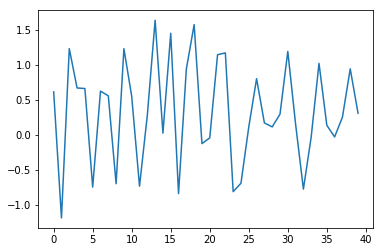

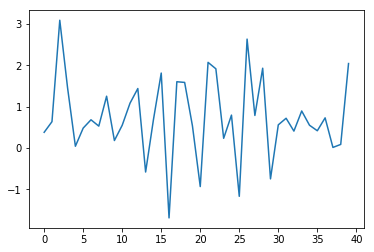

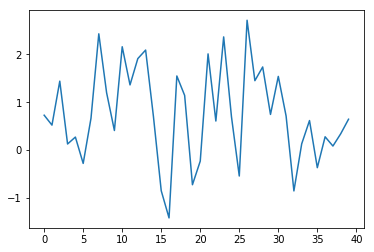

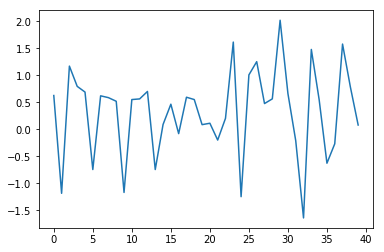

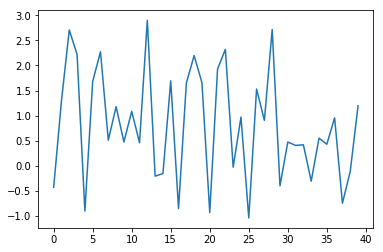

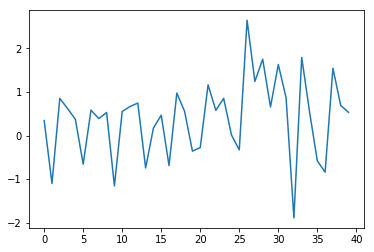

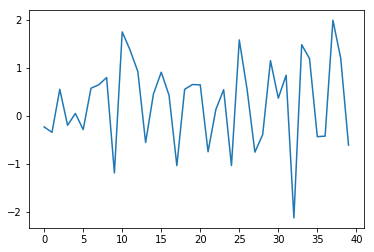

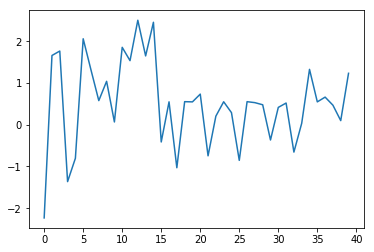

In [46]:
for i in range(len(X_test)):
    if i % 15 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test_encoded[i].ravel())